# Backtested Returns

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\TreasuryInflationPCA\root\src")
from DataPreprocess import InflationPCA

## Analyzing PCA Signals

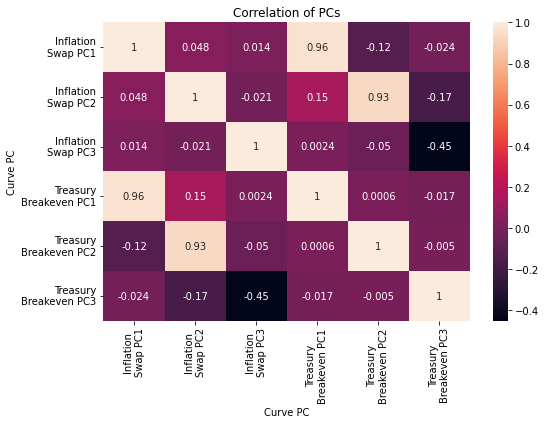

In [3]:
def get_correlation() -> pd.DataFrame: 
    
    df_corr = (InflationPCA().get_pca().drop(
        columns = ["spread", "lag_spread"]).
        rename(columns = {
            "inflation_swap": "Inflation\nSwap",
            "tsy_breakeven" : "Treasury\nBreakeven"}).
        melt(id_vars = ["date", "variable"]).
        assign(variable = lambda x: x.curve + " " + x.variable)
        [["date", "variable", "value"]].
        pivot(index = "date", columns = "variable", values = "value").
        corr())
    
    return df_corr

def plot_correlation(df_corr: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(figsize = (8,6))
    sns.heatmap(
        data   = df_corr,
        annot  = True,
        ax     = axes)

    axes.set_xlabel("Curve PC")
    axes.set_ylabel("Curve PC")
    axes.set_title("Correlation of PCs")
    plt.tight_layout()
    
df_corr = get_correlation()
plot_correlation(df_corr)

The first and second principal components have high correlation so trading the spread between the two will be difficult while for the third PC it will be difficult.

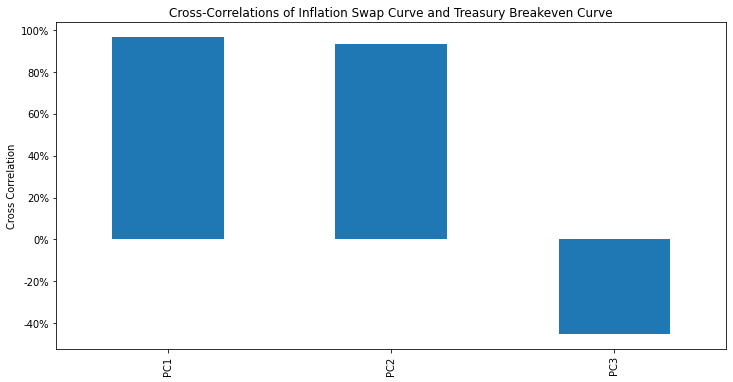

In [4]:
def plot_cross_correlations(df_corr: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(figsize = (12,6))

    (df_corr.reset_index().rename(
        columns = {"variable": "var1"}).
        melt(id_vars = "var1").
        query("variable != var1").
        assign(
            end1 = lambda x: x.var1.str.split(" ").str[-1],
            end2 = lambda x: x.variable.str.split(" ").str[-1]).
        query("end1 == end2").
        groupby("end1").
        head(1)
        [["end1", "value"]].
        rename(columns = {"end1": "PC"}).
        set_index("PC").
        plot(
            ax     = axes,
            kind   = "bar",
            legend = False,
            xlabel = "",
            ylabel = "Cross Correlation",
            title  = "Cross-Correlations of Inflation Swap Curve and Treasury Breakeven Curve"))

    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))
    
plot_cross_correlations(df_corr)

Trading the difference between the PC3 will be difficult since it has such low cross-correlations. 

## Applying Signal to Treasury Returns

In [5]:
def get_backtest() -> pd.DataFrame: 
    
    df_backtest = (InflationPCA().get_pca().merge(
        right = InflationPCA().get_tsy_fut(), how = "inner", on = ["date"]).
        assign(signal_bps = lambda x: np.sign(x.lag_spread) * x.PX_bps))
    
    return df_backtest

df_backtest = get_backtest()

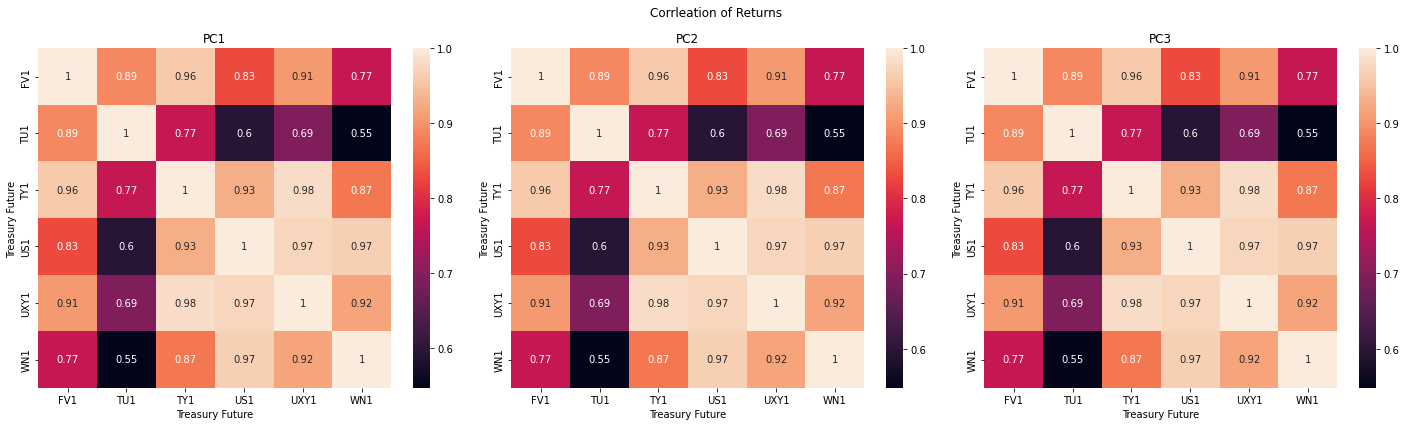

In [6]:
def plot_correlation(df_backtest: pd.DataFrame) -> plt.Figure: 
    
    variables = df_backtest.variable.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(variables), figsize = (20,6))

    for variable, ax in zip(variables, axes.flatten()):

        df_corr = (df_backtest.query(
            "variable == @variable")
            [["date", "signal_bps", "security"]].
            assign(security = lambda x: x.security.str.split(" ").str[0]).
            pivot(index = "date", columns = "security", values = "signal_bps").
            corr())

        sns.heatmap(
            data  = df_corr,
            annot = True,
            ax    = ax)

        ax.set_xlabel("Treasury Future")
        ax.set_ylabel("Treasury Future")
        ax.set_title(variable)

    fig.suptitle("Corrleation of Returns")
    plt.tight_layout()
    
plot_correlation(df_backtest)

Now backtest returns

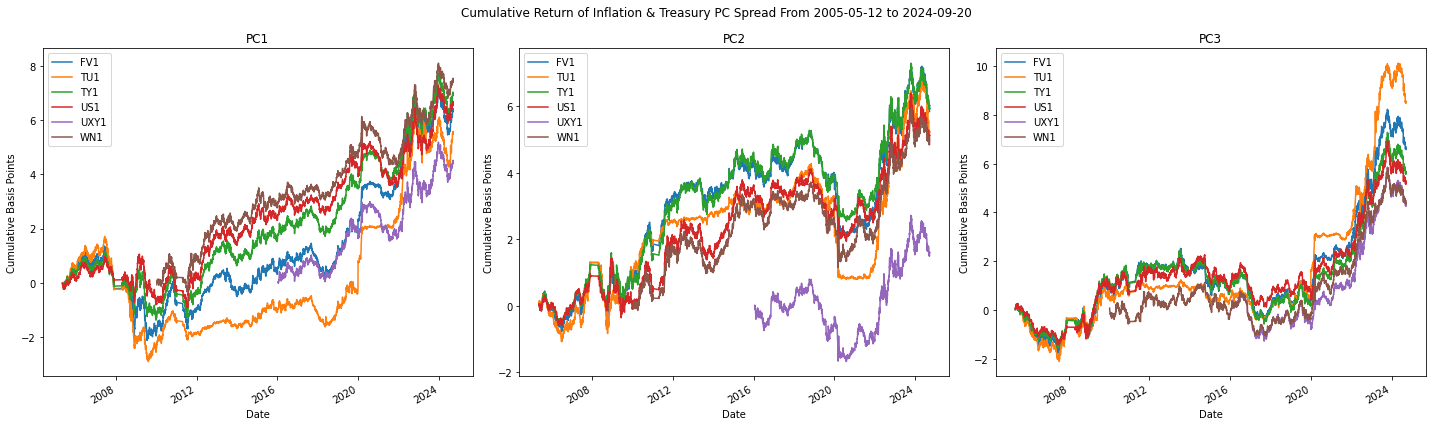

In [7]:
def plot_cum_rtn(df_backtest: pd.DataFrame) -> plt.Figure: 
    
    variables = df_backtest.variable.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(variables), figsize = (20,6))

    for variable, ax in zip(variables, axes.flatten()):

        (df_backtest.query(
            "variable == @variable")
            [["date", "security", "signal_bps"]].
            assign(security = lambda x: x.security.str.split(" ").str[0]).
            rename(columns = {"security": ""}).
            pivot(index = "date", columns = "", values = "signal_bps").
            cumsum().
            plot(
                ylabel = "Cumulative Basis Points",
                title  = variable,
                xlabel = "Date",
                ax     = ax))

    fig.suptitle("Cumulative Return of Inflation & Treasury PC Spread From {} to {}".format(
        df_backtest.date.min().date(),
        df_backtest.date.max().date()))
    
    plt.tight_layout()
    
plot_cum_rtn(df_backtest)

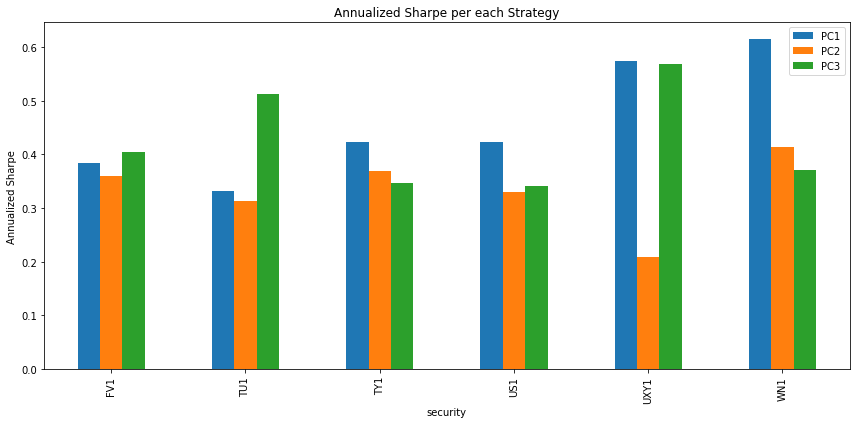

In [8]:
def plot_sharpe(df_backtest: pd.DataFrame) -> plt.Figure: 
    
    (df_backtest[
        ["variable", "security", "signal_bps"]].
        groupby(["variable", "security"]).
        agg(["mean", "std"])
        ["signal_bps"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index()
        [["variable", "security", "sharpe"]].
        assign(security = lambda x: x.security.str.split(" ").str[0]).
        rename(columns = {"variable": ""}).
        pivot(index = "security", columns = "", values = "sharpe").
        plot(
            kind    = "bar",
            ylabel  = "Annualized Sharpe",
            figsize = (12,6),
            title   = "Annualized Sharpe per each Strategy"))
    
    plt.tight_layout()
    
plot_sharpe(df_backtest)

## Equal Risk Contribution across PCs

In [9]:
def _get_vol(df: pd.DataFrame, window: int) -> pd.DataFrame: 
    
    return(df.sort_values(
        "date").
        assign(
            vol     = lambda x: x.signal_bps.rolling(window = window).std(),
            lag_vol = lambda x: x.vol.shift()))

def _get_erc(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_tmp = (df.sort_values(
        "date").
        assign(inv_vol = lambda x: 1 / x.lag_vol))
    
    df_out = (df_tmp[
        ["date", "inv_vol"]].
        groupby("date").
        agg("sum").
        rename(columns = {"inv_vol": "full_vol"}).
        merge(right = df_tmp, how = "inner", on = ["date"]).
        assign(weight = lambda x: x.inv_vol / x.full_vol))
    
    return df_out

def get_erc_weighting(df_backtest: pd.DataFrame, window: int = 30) -> pd.DataFrame: 

    df_weight = (df_backtest.groupby([
        "variable", "security"]).
        apply(_get_vol, window).
        reset_index(drop = True).
        dropna().
        groupby("variable").
        apply(_get_erc).
        reset_index(drop = True).
        assign(weight_rtn = lambda x: x.weight * x.signal_bps))
    
    return df_weight

df_weight = get_erc_weighting(df_backtest)

In [10]:
def get_erc_rtn(df_weight: pd.DataFrame) -> pd.DataFrame: 
    
    df_erc = (df_weight[
        ["date", "variable", "weight_rtn"]].
        groupby(["date", "variable"]).
        agg("sum").
        reset_index().
        rename(columns = {"variable": ""}).
        pivot(index = "date", columns = "", values = "weight_rtn"))
    
    return df_erc

df_erc = get_erc_rtn(df_weight)

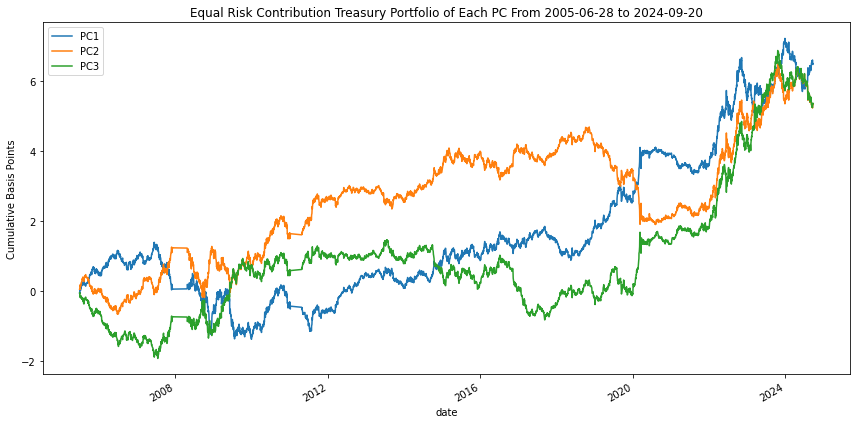

In [11]:
def plot_erc_rtn(df_erc: pd.DataFrame) -> pd.DataFrame:
    
    (df_erc.cumsum().plot(
        figsize = (12,6),
        ylabel  = "Cumulative Basis Points",
        title   = "Equal Risk Contribution Treasury Portfolio of Each PC From {} to {}".format(
            df_erc.index.min().date(),
            df_erc.index.max().date())))
    
    plt.tight_layout()
    
plot_erc_rtn(df_erc)

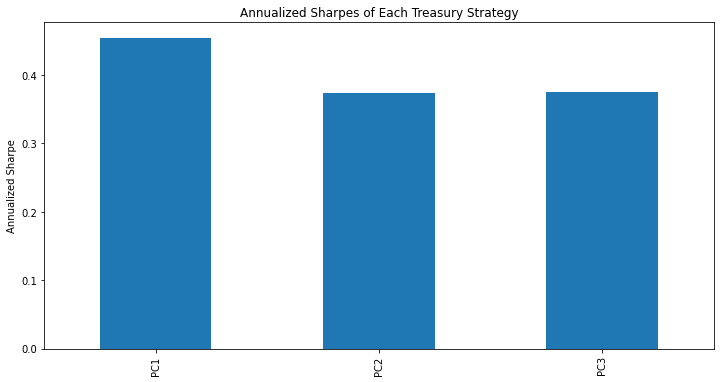

In [12]:
def plot_sharpe(df_erc: pd.DataFrame) -> plt.Figure: 
    
    (df_erc.reset_index().melt(
        id_vars = "date").
        drop(columns = ["date"]).
        rename(columns = {"": "variable"}).
        groupby("variable").
        agg(["mean", "std"])
        ["value"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
        [["sharpe"]].
        plot(
            kind    = "bar",
            xlabel  = "",
            ylabel  = "Annualized Sharpe",
            legend  = False,
            figsize = (12,6),
            title   = "Annualized Sharpes of Each Treasury Strategy"))
    
plot_sharpe(df_erc)

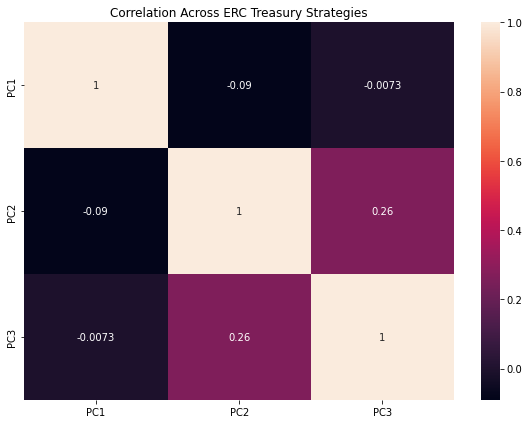

In [13]:
def plot_erc_corr(df_erc: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(figsize = (8,6))

    sns.heatmap(
        ax    = axes,
        data  = df_erc.corr(),
        annot = True)

    axes.set_title("Correlation Across ERC Treasury Strategies")
    plt.tight_layout()
    
plot_erc_corr(df_erc)

## Equal Risk Contribution across Futures

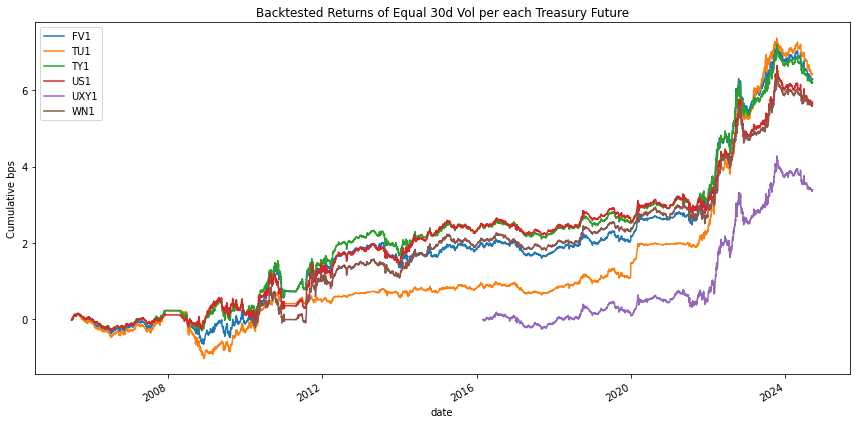

In [44]:
def _get_vol(df: pd.DataFrame, window: int) -> pd.DataFrame: 
    
    df_out = (df.sort_values(
        "date").
        assign(
            roll_vol = lambda x: x.signal_bps.rolling(window = window).std(),
            lag_vol  = lambda x: x.roll_vol.shift()).
        dropna())
    
    return df_out

def plot_erc(df_backtest: pd.DataFrame, window: int = 30) -> plt.Figure: 

    df_tmp = (df_backtest[
        ["date", "variable", "security", "signal_bps"]].
        groupby(["variable", "security"]).
        apply(_get_vol, window).
        reset_index(drop = True).
        assign(inv_vol = lambda x: 1 / x.lag_vol))

    df_cum = (df_tmp[
        ["date", "security", "inv_vol"]].
        groupby(["date", "security"]).
        agg("sum").
        reset_index().
        rename(columns = {"inv_vol": "cum_vol"}))

    (df_tmp.merge(
        right = df_cum, how = "inner", on = ["date", "security"]).
        assign(
            security     = lambda x: x.security.str.split(" ").str[0],
            weighted_rtn = lambda x: x.inv_vol / x.cum_vol * x.signal_bps)
        [["date", "security", "weighted_rtn"]].
        groupby(["date", "security"]).
        agg("sum").
        reset_index().
        rename(columns = {"security": ""}).
        pivot(index = "date", columns = "", values = "weighted_rtn").
        cumsum().
        plot(
            ylabel  = "Cumulative bps",
            figsize = (12,6),
            title   = "Backtested Returns of Equal 30d Vol per each Treasury Future"))
    
    plt.tight_layout()
    
plot_erc(df_backtest)